In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [3]:
path = "/content/drive/MyDrive/dissertation file/Disssertation testing /Superstoredataset.csv"
df= pd.read_csv(path)
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2020-152156,08/11/2020,11/11/2020,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2020-152156,08/11/2020,11/11/2020,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2020-138688,12/06/2020,16/06/2020,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2019-108966,11/10/2019,18/10/2019,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2019-108966,11/10/2019,18/10/2019,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
df['Order Date'] = pd.to_datetime(df['Order Date'],format = '%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format = '%d/%m/%Y')
print(df.dtypes)

Row ID                     int64
Order ID                  object
Order Date        datetime64[ns]
Ship Date         datetime64[ns]
Ship Mode                 object
Customer ID               object
Customer Name             object
Segment                   object
Country/Region            object
City                      object
State                     object
Postal Code              float64
Region                    object
Product ID                object
Category                  object
Sub-Category              object
Product Name              object
Sales                    float64
Quantity                   int64
Discount                 float64
Profit                   float64
dtype: object


**Dropping irrelevant columns**

In [5]:
#dropping irrelevant columns
df.drop(['Row ID', 'Order ID','Ship Mode','Segment','Customer Name','Country/Region','Product ID','Product Name','Postal Code'],axis =1, inplace = True)

**Check how many unique values are in each column**

In [6]:
category_col = ['City', 'State', 'Region', 'Category', 'Sub-Category']

# Get the number of distinct values for each specified column
distinct_values = df[category_col].nunique()
print(distinct_values)

City            531
State            49
Region            4
Category          3
Sub-Category     17
dtype: int64


**Since City' has 531 unique values, and State has 49 unique values, which can significantly increase the dimensionality when using one-hot encoding, decide to remove it**


In [7]:

df.drop(['City','State'], axis = 1, inplace = True)
df.head()

,Order Date,Ship Date,Customer ID,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,2020-11-08,2020-11-11,CG-12520,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,2020-11-08,2020-11-11,CG-12520,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,2020-06-12,2020-06-16,DV-13045,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,2019-10-11,2019-10-18,SO-20335,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,2019-10-11,2019-10-18,SO-20335,South,Office Supplies,Storage,22.3680,2,0.20,2.5164


**check duplicate column**

In [8]:
df[df.duplicated()]

,Order Date,Ship Date,Customer ID,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
3406,2018-04-23,2018-04-27,LB-16795,East,Furniture,Chairs,281.372,2,0.3,-12.0588


In [9]:
duplicate_rows_df = df[df.duplicated()]

#shape[0] is used to get the count of rows,  shape[1]) is the number of columns
print(f"Number of duplicate rows: {duplicate_rows_df.shape[0]}")

Number of duplicate rows: 1


In [10]:
df_cleaned = df.drop_duplicates()
df_cleaned.shape

(9993, 10)

## Caculating RFM

In [11]:
reference_date = df_cleaned['Order Date'].max()
recency_df = df_cleaned.groupby('Customer ID')['Order Date'].max().reset_index()
recency_df.columns = ['Customer ID', 'Last Purchase Date']
recency_df['Recency']= (reference_date - recency_df['Last Purchase Date']).dt.days
print(recency_df)

frequency_df = df_cleaned.groupby('Customer ID')['Order Date'].count().reset_index()
frequency_df.columns = ['Customer ID', 'Frequency']
print(frequency_df)

monetary_df = df_cleaned.groupby('Customer ID')['Sales'].sum().reset_index()
monetary_df.columns = ['Customer ID', 'Monetary']
print(monetary_df)

profit_df = df_cleaned.groupby('Customer ID')['Profit'].sum().reset_index()
profit_df.columns = ['Customer ID', 'Profit']
print(profit_df)

RFM_df = recency_df.merge(frequency_df, on = 'Customer ID').merge(monetary_df, on = 'Customer ID').merge(profit_df, on = 'Customer ID')
RFM_df['AvgPurchaseValue'] = RFM_df['Monetary']/RFM_df['Frequency']

total_order_number = RFM_df['Frequency'].sum()
print(total_order_number)
total_unique_customers = RFM_df.shape[0]

Purchase_frequency = total_order_number/total_unique_customers


total_order_number_greater_than_1 = RFM_df[RFM_df['Frequency'] > 1].shape[0]

total_unique_customers = RFM_df.shape[0]
retention_rate = total_order_number_greater_than_1 / total_unique_customers
churn_rate = 1 - retention_rate
print(f"Churn Rate: {churn_rate}")

RFM_df['profit_margin'] = RFM_df['Profit']/RFM_df['Monetary']

RFM_df['CLV'] = ((RFM_df['AvgPurchaseValue']*Purchase_frequency)/churn_rate)* RFM_df['profit_margin']
RFM_df

    Customer ID Last Purchase Date  Recency
0      AA-10315         2021-06-29      184
1      AA-10375         2021-12-11       19
2      AA-10480         2021-04-15      259
3      AA-10645         2021-11-05       55
4      AB-10015         2020-11-10      415
..          ...                ...      ...
788    XP-21865         2021-11-17       43
789    YC-21895         2021-12-26        4
790    YS-21880         2021-12-21        9
791    ZC-21910         2021-11-06       54
792    ZD-21925         2021-06-11      202

[793 rows x 3 columns]
    Customer ID  Frequency
0      AA-10315         11
1      AA-10375         15
2      AA-10480         12
3      AA-10645         18
4      AB-10015          6
..          ...        ...
788    XP-21865         28
789    YC-21895          8
790    YS-21880         12
791    ZC-21910         31
792    ZD-21925          9

[793 rows x 2 columns]
    Customer ID  Monetary
0      AA-10315  5563.560
1      AA-10375  1056.390
2      AA-10480  1790.

,Customer ID,Last Purchase Date,Recency,Frequency,Monetary,Profit,AvgPurchaseValue,profit_margin,CLV
0,AA-10315,2021-06-29,184,11,5563.560,-362.8825,505.778182,-0.065225,-65932.451318
1,AA-10375,2021-12-11,19,15,1056.390,277.3824,70.426000,0.262576,36958.430976
2,AA-10480,2021-04-15,259,12,1790.512,435.8274,149.209333,0.243409,72587.053470
3,AA-10645,2021-11-05,55,18,5086.935,857.8033,282.607500,0.168629,95244.759743
4,AB-10015,2020-11-10,415,6,886.156,129.3465,147.692667,0.145964,43085.319150
...,...,...,...,...,...,...,...,...,...
788,XP-21865,2021-11-17,43,28,2374.658,621.2300,84.809214,0.261608,44342.509929
789,YC-21895,2021-12-26,4,8,5454.350,1305.6290,681.793750,0.239374,326178.764925
790,YS-21880,2021-12-21,9,12,6720.444,1778.2923,560.037000,0.264609,296174.582565
791,ZC-21910,2021-11-06,54,31,8025.707,-1032.1490,258.893774,-0.128605,-66543.644884


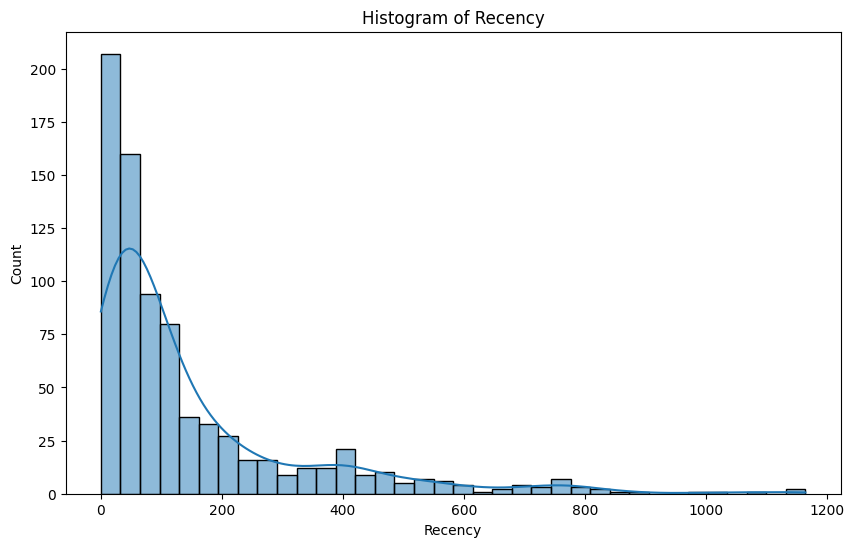

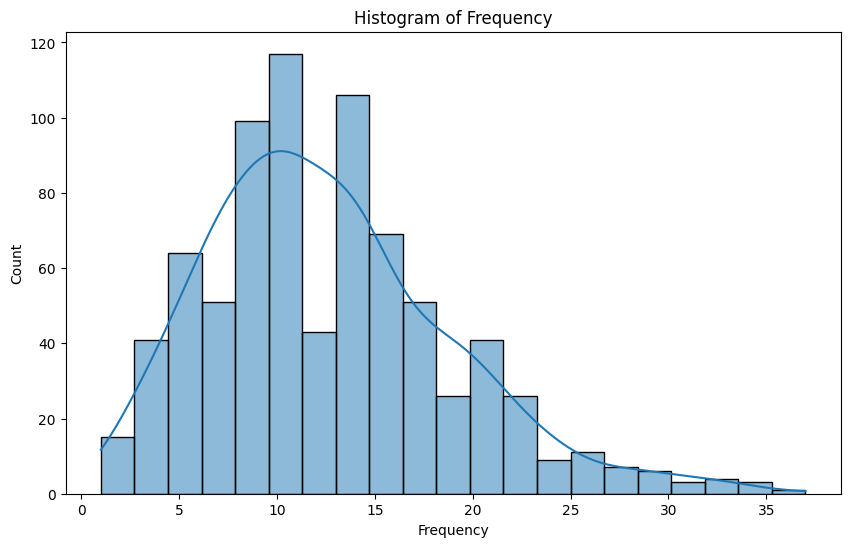

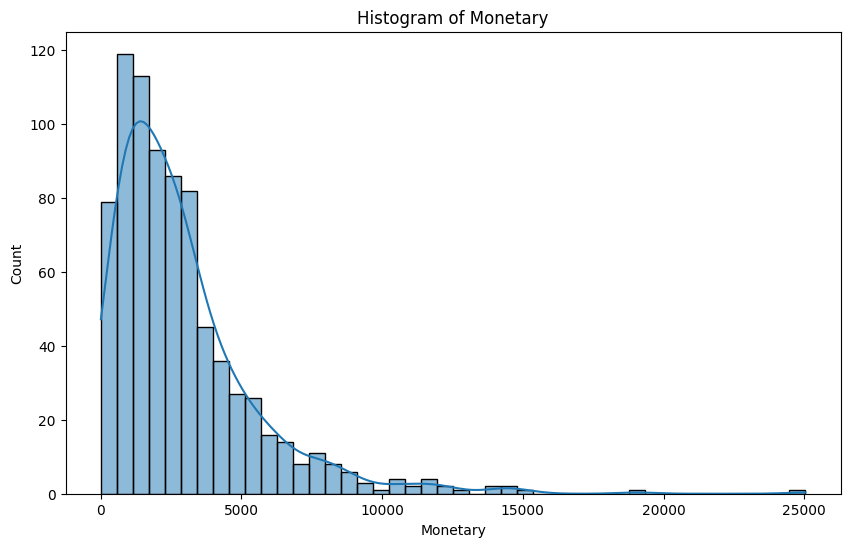

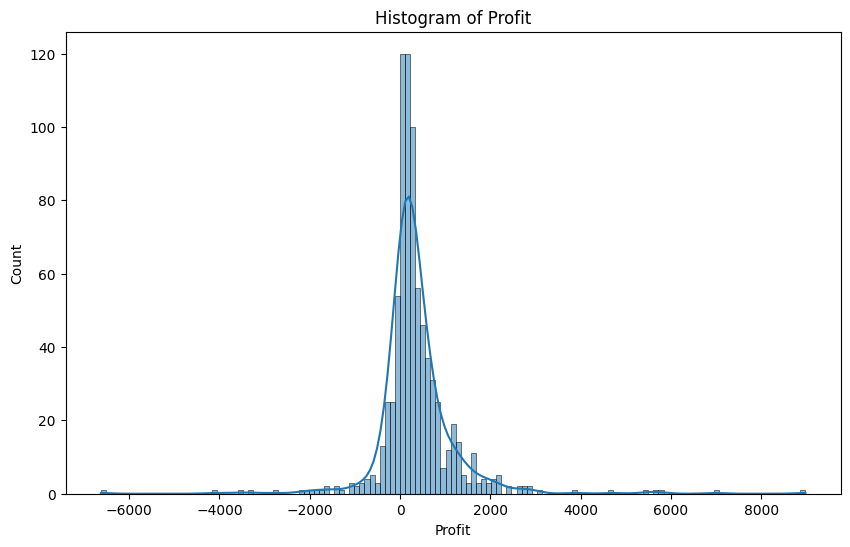

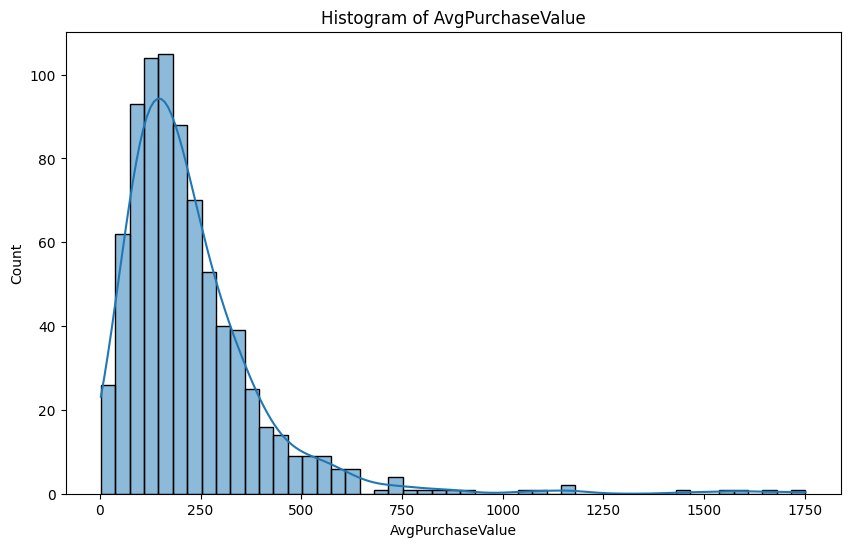

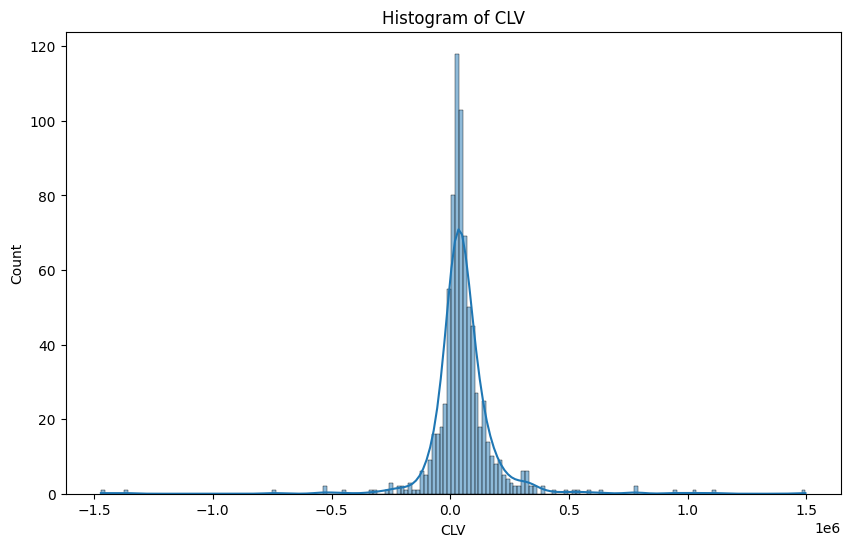

In [12]:
# Check the distribution of features
numerical_cols = ['Recency', 'Frequency', 'Monetary', 'Profit', 'AvgPurchaseValue', 'CLV']

for feature in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(RFM_df[feature], kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

In [13]:
#Since the data is non-normally distribution, and min-max is less sensitive to outliers

numerical_cols = ['Recency', 'Frequency', 'Monetary', 'Profit', 'AvgPurchaseValue', 'CLV']
scaler = MinMaxScaler()
CLV_scaled = scaler.fit_transform(RFM_df[numerical_cols])
CLV_scaled_df = pd.DataFrame(CLV_scaled, columns=['Recency', 'Frequency', 'Monetary','Profit','AvgPurchaseValue','CLV'])
print(CLV_scaled_df.head())

    Recency  Frequency  Monetary    Profit  AvgPurchaseValue       CLV
0  0.157940   0.277778  0.222010  0.401308          0.287820  0.473679
1  0.016309   0.388889  0.041998  0.442331          0.038888  0.508354
2  0.222318   0.305556  0.071318  0.452482          0.083936  0.520361
3  0.047210   0.472222  0.202974  0.479519          0.160212  0.527996
4  0.356223   0.138889  0.035199  0.432846          0.083068  0.510419


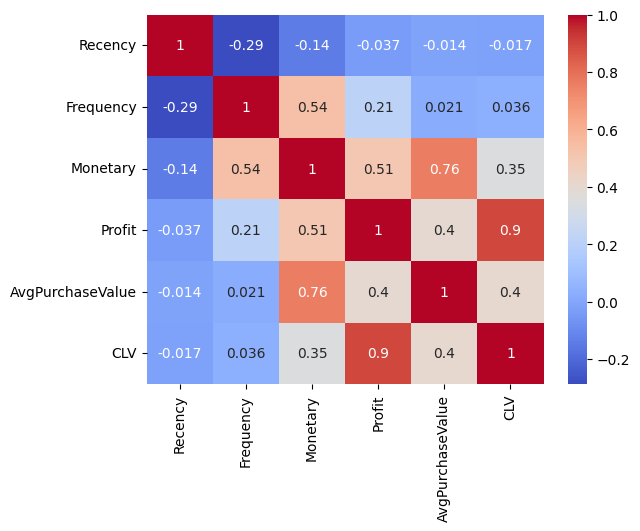

In [14]:
correlation_matrix = CLV_scaled_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [15]:
CLV_scaled_df.drop(['Profit'], axis = 1, inplace = True)

CLV_scaled_df

,Recency,Frequency,Monetary,AvgPurchaseValue,CLV
0,0.157940,0.277778,0.222010,0.287820,0.473679
1,0.016309,0.388889,0.041998,0.038888,0.508354
2,0.222318,0.305556,0.071318,0.083936,0.520361
3,0.047210,0.472222,0.202974,0.160212,0.527996
4,0.356223,0.138889,0.035199,0.083068,0.510419
...,...,...,...,...,...
788,0.036910,0.750000,0.094648,0.047112,0.510842
789,0.003433,0.194444,0.217648,0.388465,0.605822
790,0.007725,0.305556,0.268214,0.318845,0.595710
791,0.046352,0.833333,0.320345,0.146653,0.473473


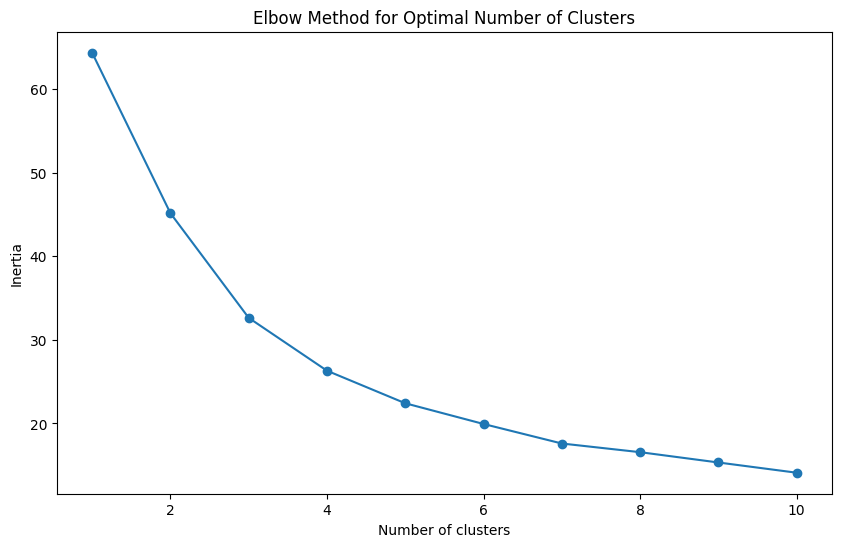

In [16]:

inertia = []
# Define range of k values to try

range_of_clusters = range(1,11)
# Loop over possible values of k
for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init= 'auto')
    kmeans.fit(CLV_scaled_df[['Recency', 'Frequency', 'Monetary','AvgPurchaseValue','CLV']])
    inertia.append(kmeans.inertia_)


# Plotting the elbow plot to find the optimal k
plt.figure(figsize=(10, 6))
plt.plot(range_of_clusters, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [17]:
from sklearn.metrics import silhouette_score
for k in [3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(CLV_scaled_df[['Recency', 'Frequency', 'Monetary','AvgPurchaseValue','CLV']])
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(CLV_scaled_df, labels)
    print(f'For k={k}, Inertia: {inertia}, Silhouette Score: {silhouette_avg}')

    # Add cluster labels to the DataFrame
    CLV_scaled_df[f'Cluster_{k}'] = labels


CLV_scaled_df.drop('Cluster_3', axis=1, inplace=True)
CLV_scaled_df

For k=3, Inertia: 32.62485180486541, Silhouette Score: 0.3565443601848899
For k=4, Inertia: 26.303149444168458, Silhouette Score: 0.6598128944460548


,Recency,Frequency,Monetary,AvgPurchaseValue,CLV,Cluster_4
0,0.157940,0.277778,0.222010,0.287820,0.473679,3
1,0.016309,0.388889,0.041998,0.038888,0.508354,1
2,0.222318,0.305556,0.071318,0.083936,0.520361,1
3,0.047210,0.472222,0.202974,0.160212,0.527996,0
4,0.356223,0.138889,0.035199,0.083068,0.510419,2
...,...,...,...,...,...,...
788,0.036910,0.750000,0.094648,0.047112,0.510842,0
789,0.003433,0.194444,0.217648,0.388465,0.605822,3
790,0.007725,0.305556,0.268214,0.318845,0.595710,3
791,0.046352,0.833333,0.320345,0.146653,0.473473,0


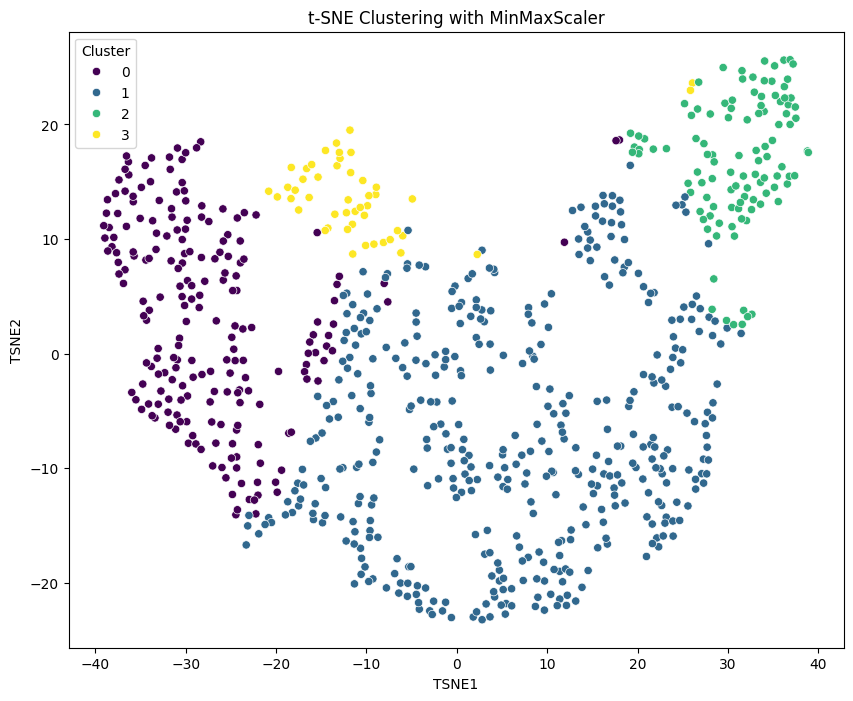

In [18]:
from sklearn.manifold import TSNE

features = ['Recency', 'Frequency', 'Monetary', 'AvgPurchaseValue', 'CLV']
X = CLV_scaled_df[features]
y = CLV_scaled_df['Cluster_4']

# Apply t-SNE to reduce the data to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = y

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis', data=tsne_df)
plt.title('t-SNE Clustering with MinMaxScaler')
plt.show()

In [19]:
cluster_4_summary = CLV_scaled_df.groupby('Cluster_4').mean()
print(cluster_4_summary)

            Recency  Frequency  Monetary  AvgPurchaseValue       CLV
Cluster_4                                                           
0          0.063519   0.547465  0.170320          0.116265  0.510409
1          0.075040   0.247492  0.075854          0.107774  0.509134
2          0.458695   0.183899  0.060301          0.110662  0.506729
3          0.103936   0.340426  0.366304          0.420540  0.595773


In [20]:
centroids = kmeans.cluster_centers_
print('Cluster Centroids:')
print(centroids)

Cluster Centroids:
[[0.06351931 0.54746494 0.17032026 0.11626518 0.51040857]
 [0.07503974 0.24749228 0.07585351 0.10777352 0.50913426]
 [0.45869496 0.18389918 0.06030099 0.11066186 0.50672909]
 [0.10393571 0.34042553 0.36630381 0.4205404  0.59577315]]


In [21]:
def categorize_cluster(cluster_id):
    # Define cluster characteristics manually based on descriptive analysis
    if cluster_id == 0:
        return 'Medium to High'
    elif cluster_id == 1:
        return 'Medium to Low'
    elif cluster_id == 2:
        return 'Low'
    elif cluster_id == 3:
        return 'High'


CLV_scaled_df['Cluster'] = CLV_scaled_df['Cluster_4'].map(categorize_cluster)

customer_ids = RFM_df['Customer ID']
CLV_scaled_df.insert(0, 'Customer ID', customer_ids)

# Display the updated CLV_scaled_df
print(CLV_scaled_df.head())


cluster_df = CLV_scaled_df[['Customer ID','Cluster']]

merged_cluster_df = df_cleaned.merge(cluster_df, on='Customer ID', how='left')
print("Merged_cluster_df:")
merged_cluster_df

  Customer ID   Recency  Frequency  Monetary  AvgPurchaseValue       CLV  \
0    AA-10315  0.157940   0.277778  0.222010          0.287820  0.473679   
1    AA-10375  0.016309   0.388889  0.041998          0.038888  0.508354   
2    AA-10480  0.222318   0.305556  0.071318          0.083936  0.520361   
3    AA-10645  0.047210   0.472222  0.202974          0.160212  0.527996   
4    AB-10015  0.356223   0.138889  0.035199          0.083068  0.510419   

   Cluster_4         Cluster  
0          3            High  
1          1   Medium to Low  
2          1   Medium to Low  
3          0  Medium to High  
4          2             Low  
Merged_cluster_df:


,Order Date,Ship Date,Customer ID,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Cluster
0,2020-11-08,2020-11-11,CG-12520,South,Furniture,Bookcases,261.9600,2,0.00,41.9136,Low
1,2020-11-08,2020-11-11,CG-12520,South,Furniture,Chairs,731.9400,3,0.00,219.5820,Low
2,2020-06-12,2020-06-16,DV-13045,West,Office Supplies,Labels,14.6200,2,0.00,6.8714,Medium to Low
3,2019-10-11,2019-10-18,SO-20335,South,Furniture,Tables,957.5775,5,0.45,-383.0310,Medium to Low
4,2019-10-11,2019-10-18,SO-20335,South,Office Supplies,Storage,22.3680,2,0.20,2.5164,Medium to Low
...,...,...,...,...,...,...,...,...,...,...,...
9988,2018-01-21,2018-01-23,TB-21400,South,Furniture,Furnishings,25.2480,3,0.20,4.1028,High
9989,2021-02-26,2021-03-03,DB-13060,West,Furniture,Furnishings,91.9600,2,0.00,15.6332,Medium to Low
9990,2021-02-26,2021-03-03,DB-13060,West,Technology,Phones,258.5760,2,0.20,19.3932,Medium to Low
9991,2021-02-26,2021-03-03,DB-13060,West,Office Supplies,Paper,29.6000,4,0.00,13.3200,Medium to Low


In [22]:
cluster_df = CLV_scaled_df[['Customer ID','Cluster']]

merged_cluster_df = df_cleaned.merge(cluster_df, on='Customer ID', how='left')
merged_cluster_df

,Order Date,Ship Date,Customer ID,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Cluster
0,2020-11-08,2020-11-11,CG-12520,South,Furniture,Bookcases,261.9600,2,0.00,41.9136,Low
1,2020-11-08,2020-11-11,CG-12520,South,Furniture,Chairs,731.9400,3,0.00,219.5820,Low
2,2020-06-12,2020-06-16,DV-13045,West,Office Supplies,Labels,14.6200,2,0.00,6.8714,Medium to Low
3,2019-10-11,2019-10-18,SO-20335,South,Furniture,Tables,957.5775,5,0.45,-383.0310,Medium to Low
4,2019-10-11,2019-10-18,SO-20335,South,Office Supplies,Storage,22.3680,2,0.20,2.5164,Medium to Low
...,...,...,...,...,...,...,...,...,...,...,...
9988,2018-01-21,2018-01-23,TB-21400,South,Furniture,Furnishings,25.2480,3,0.20,4.1028,High
9989,2021-02-26,2021-03-03,DB-13060,West,Furniture,Furnishings,91.9600,2,0.00,15.6332,Medium to Low
9990,2021-02-26,2021-03-03,DB-13060,West,Technology,Phones,258.5760,2,0.20,19.3932,Medium to Low
9991,2021-02-26,2021-03-03,DB-13060,West,Office Supplies,Paper,29.6000,4,0.00,13.3200,Medium to Low


## Customer Segmentation Analysis (Region)

In [23]:
grouped = merged_cluster_df.groupby(['Cluster', 'Region'])['Sales'].sum().reset_index()
grouped_sorted = grouped.sort_values(['Cluster', 'Sales'], ascending=[True, False])
grouped_sorted


,Cluster,Region,Sales
1,High,East,64374.2210
0,High,Central,63760.8140
2,High,South,56960.3890
3,High,West,37846.2400
5,Low,East,56372.5030
7,Low,West,54825.7390
4,Low,Central,38141.3092
6,Low,South,29121.6945
11,Medium to High,West,300511.7615
9,Medium to High,East,231497.4850


In [24]:
# Step 1: Group by Cluster and Region, and Sum the Sales
grouped_sales = merged_cluster_df.groupby(['Cluster', 'Region'])['Sales'].sum().reset_index()

# Step 2: Calculate the Total Sales for Each Region
total_sales_by_region = grouped_sales.groupby('Region')['Sales'].sum().reset_index()
total_sales_by_region = total_sales_by_region.rename(columns={'Sales': 'Total_Sales'})
print(total_sales_by_region)

# Step 3: Merge the Total Sales with Grouped Sales Data
merged_sales = pd.merge(grouped_sales, total_sales_by_region, on='Region')
print(merged_sales)

# Step 4: Calculate the Percentage of Sales
merged_sales['Percentage'] = (merged_sales['Sales'] / merged_sales['Total_Sales']) * 100

percentage_sales_sorted = merged_sales.sort_values(['Cluster', 'Percentage'], ascending=[True, False])
print(percentage_sales_sorted)

    Region  Total_Sales
0  Central  501239.8908
1     East  678499.8680
2    South  391721.9050
3     West  725457.8245
           Cluster   Region        Sales  Total_Sales
0             High  Central   63760.8140  501239.8908
1             High     East   64374.2210  678499.8680
2             High    South   56960.3890  391721.9050
3             High     West   37846.2400  725457.8245
4              Low  Central   38141.3092  501239.8908
5              Low     East   56372.5030  678499.8680
6              Low    South   29121.6945  391721.9050
7              Low     West   54825.7390  725457.8245
8   Medium to High  Central  165656.2694  501239.8908
9   Medium to High     East  231497.4850  678499.8680
10  Medium to High    South  142111.2590  391721.9050
11  Medium to High     West  300511.7615  725457.8245
12   Medium to Low  Central  233681.4982  501239.8908
13   Medium to Low     East  326255.6590  678499.8680
14   Medium to Low    South  163528.5625  391721.9050
15   Medium to L

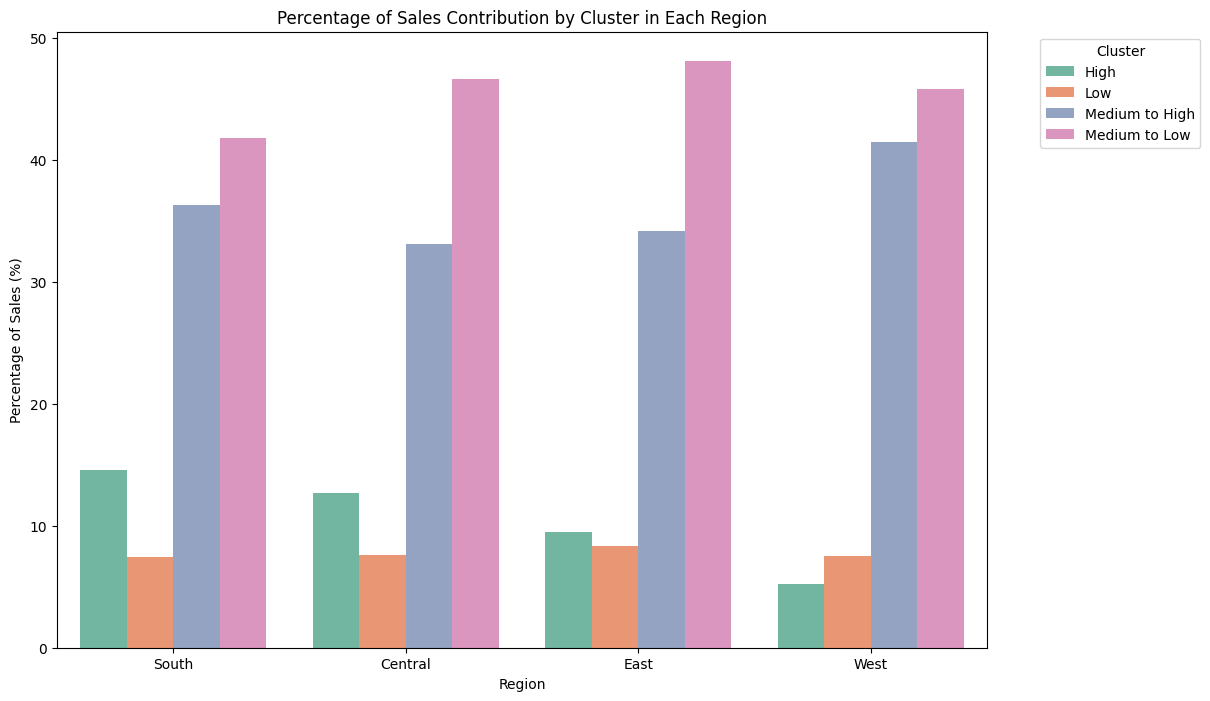

In [25]:

plt.figure(figsize=(12, 8))

# Choose a custom color palette with exactly 4 colors
custom_palette = sns.color_palette("Set2", n_colors=4)


sns.barplot(data=percentage_sales_sorted, x='Region', y='Percentage', hue='Cluster', palette=custom_palette)


plt.title('Percentage of Sales Contribution by Cluster in Each Region')
plt.xlabel('Region')
plt.ylabel('Percentage of Sales (%)')


plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.show()

## Calculate the Average Order Value (AOV) for each cluster within each region

In [26]:
total_sales_per_cluster_region = merged_cluster_df.groupby(['Cluster', 'Region'])['Sales'].sum().reset_index()

# Step 1: Calculate total number of orders per cluster and region
total_orders_per_cluster_region = merged_cluster_df.groupby(['Cluster', 'Region'])['Order Date'].count().reset_index()
total_orders_per_cluster_region = total_orders_per_cluster_region.rename(columns={'Order Date': 'Total_Orders'})
print(total_orders_per_cluster_region)
# Step 2: Merge the total sales and total orders data
merged_sales_orders = pd.merge(total_sales_per_cluster_region, total_orders_per_cluster_region, on=['Cluster', 'Region'])

# Step 3: Calculate the Average Order Value (AOV)
merged_sales_orders['AOV'] = merged_sales_orders['Sales'] / merged_sales_orders['Total_Orders']

# Step 4: Sort and display the results
aov_sorted = merged_sales_orders.sort_values(['Cluster', 'AOV'], ascending=[True, False])
print(aov_sorted)

           Cluster   Region  Total_Orders
0             High  Central            58
1             High     East            67
2             High    South            44
3             High     West            68
4              Low  Central           193
5              Low     East           276
6              Low    South           150
7              Low     West           228
8   Medium to High  Central           953
9   Medium to High     East          1193
10  Medium to High    South           673
11  Medium to High     West          1418
12   Medium to Low  Central          1119
13   Medium to Low     East          1311
14   Medium to Low    South           753
15   Medium to Low     West          1489
           Cluster   Region        Sales  Total_Orders          AOV
2             High    South   56960.3890            44  1294.554295
0             High  Central   63760.8140            58  1099.324379
1             High     East   64374.2210            67   960.809269
3             

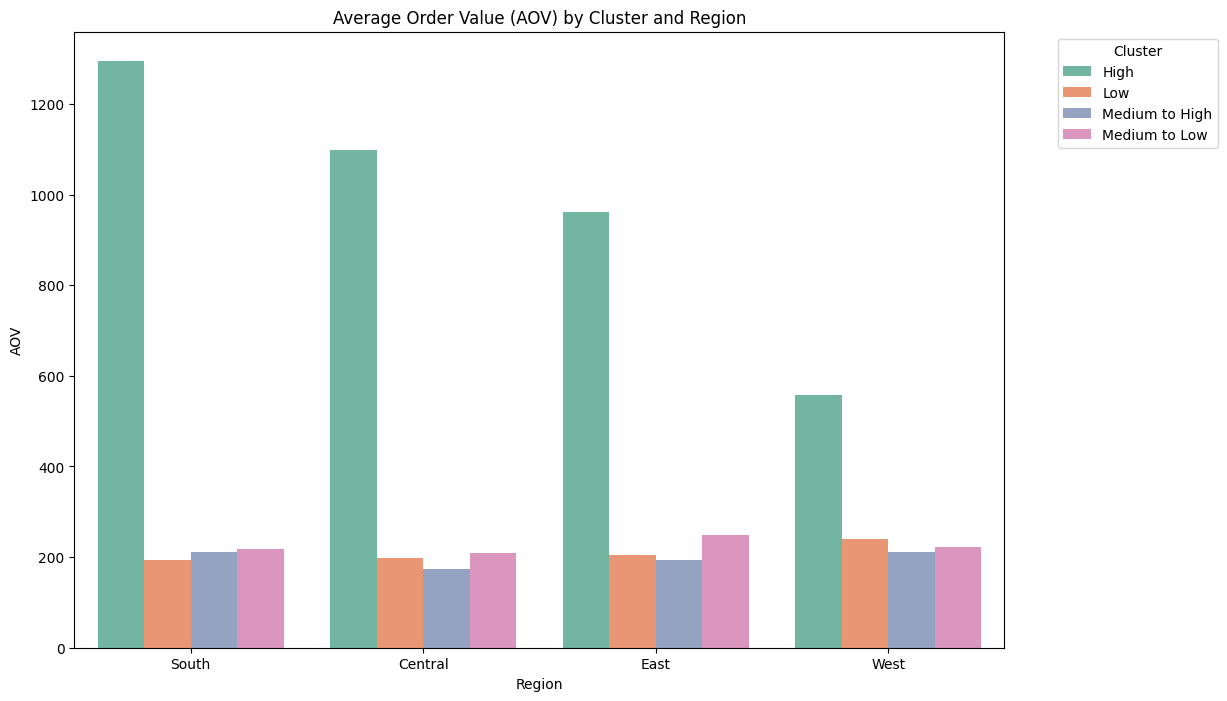

In [27]:
plt.figure(figsize=(12, 8))

# Choose a custom color palette
custom_palette = sns.color_palette("Set2", n_colors=4)

# Create a bar plot with the custom palette
sns.barplot(data=aov_sorted, x='Region', y='AOV', hue='Cluster', palette=custom_palette)

# Add titles and labels
plt.title('Average Order Value (AOV) by Cluster and Region')
plt.xlabel('Region')
plt.ylabel('AOV')

# Move the legend outside the plot
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

## Average Repeat Purchases by Cluster and Region

In [ ]:
customer_region_orders = merged_cluster_df.groupby(['Customer ID', 'Region'])['Order Date'].count().reset_index()
customer_region_orders = customer_region_orders.rename(columns={'Order Date': 'Total_Orders'})
print(customer_region_orders )

     Customer ID   Region  Total_Orders
0       AA-10315  Central             6
1       AA-10315     East             2
2       AA-10315     West             3
3       AA-10375  Central             2
4       AA-10375     East             5
...          ...      ...           ...
2496    ZC-21910    South             3
2497    ZC-21910     West            16
2498    ZD-21925  Central             2
2499    ZD-21925    South             3
2500    ZD-21925     West             4

[2501 rows x 3 columns]


In [ ]:
total_orders_per_cluster_region = merged_cluster_df.groupby(['Cluster', 'Region'])['Order Date'].count().reset_index()
total_orders_per_cluster_region = total_orders_per_cluster_region.rename(columns={'Order Date': 'Total_Orders'})
print(total_orders_per_cluster_region)

           Cluster   Region  Total_Orders
0             High  Central           150
1             High     East           159
2             High    South           104
3             High     West           210
4              Low  Central           187
5              Low     East           267
6              Low    South           149
7              Low     West           220
8   Medium to High  Central          1004
9   Medium to High     East          1208
10  Medium to High    South           695
11  Medium to High     West          1359
12   Medium to Low  Central           982
13   Medium to Low     East          1213
14   Medium to Low    South           672
15   Medium to Low     West          1414


     Customer ID   Region  Total_Orders         Cluster
0       AA-10315  Central             6            High
6       AA-10315     East             2            High
8       AA-10315     West             3            High
11      AA-10375  Central             2   Medium to Low
13      AA-10375     East             5   Medium to Low
...          ...      ...           ...             ...
9965    ZC-21910    South             3  Medium to High
9968    ZC-21910     West            16  Medium to High
9984    ZD-21925  Central             2   Medium to Low
9986    ZD-21925    South             3   Medium to Low
9989    ZD-21925     West             4   Medium to Low

[2501 rows x 4 columns]
           Cluster   Region  Avg_Repeat_Purchases
3             High     West              5.000000
1             High     East              3.878049
0             High  Central              3.750000
2             High    South              3.151515
5              Low     East              3.423077
7  

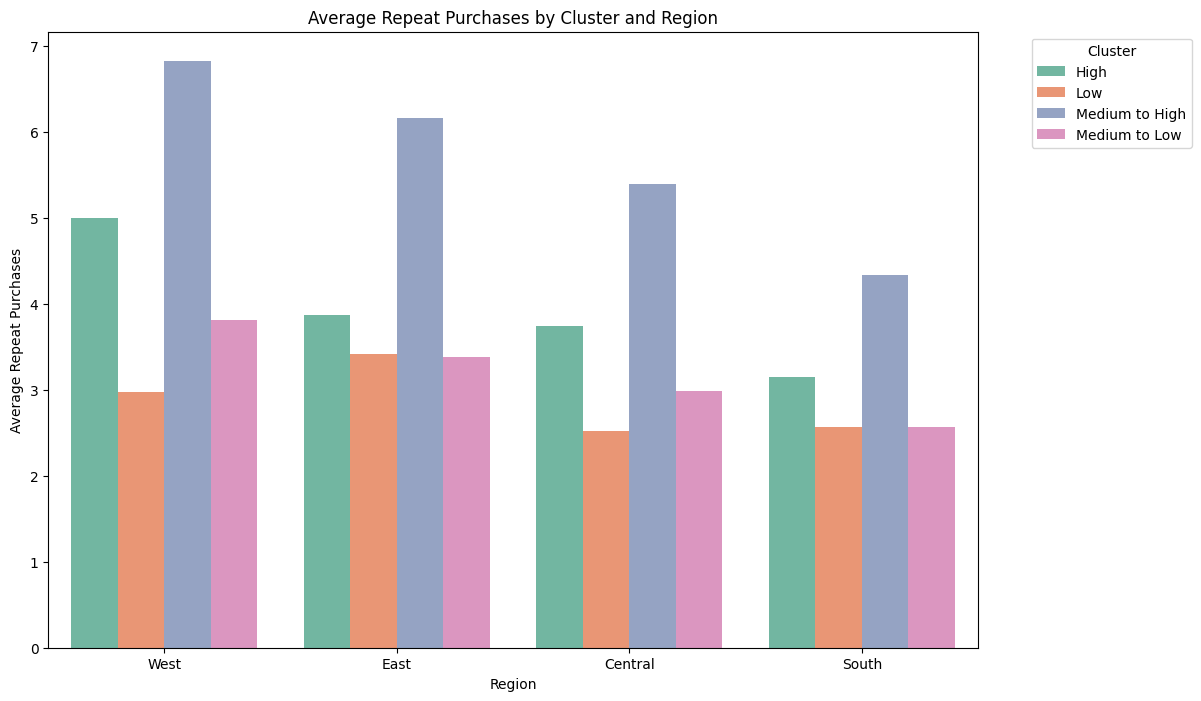

In [ ]:
customer_region_orders = merged_cluster_df.groupby(['Customer ID', 'Region'])['Order Date'].count().reset_index()
customer_region_orders = customer_region_orders.rename(columns={'Order Date': 'Total_Orders'})

# Step 2: Merge with cluster information, ensuring uniqueness
loyalty_df = pd.merge(customer_region_orders, merged_cluster_df[['Customer ID', 'Cluster', 'Region']], on=['Customer ID', 'Region'], how='left')
loyalty_df = loyalty_df.drop_duplicates()  # Ensure there are no duplicate rows
print(loyalty_df)

# Step 3: Group by Cluster and Region to calculate average repeat purchases
repeat_purchase_analysis = loyalty_df.groupby(['Cluster', 'Region'])['Total_Orders'].mean().reset_index()
repeat_purchase_analysis = repeat_purchase_analysis.rename(columns={'Total_Orders': 'Avg_Repeat_Purchases'})


repeat_purchase_sorted = repeat_purchase_analysis.sort_values(['Cluster', 'Avg_Repeat_Purchases'], ascending=[True, False])
print(repeat_purchase_sorted)

plt.figure(figsize=(12, 8))
custom_palette = sns.color_palette("Set2", n_colors=4)
sns.barplot(data=repeat_purchase_sorted, x='Region', y='Avg_Repeat_Purchases', hue='Cluster', palette=custom_palette)
plt.title('Average Repeat Purchases by Cluster and Region')
plt.xlabel('Region')
plt.ylabel('Average Repeat Purchases')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [23]:
df_encoded = pd.get_dummies(merged_cluster_df,columns=['Region', 'Category'])
aggregated_features = df_encoded.groupby('Customer ID').sum(numeric_only=True).reset_index()

aggregated_features_df = aggregated_features.drop(['Sales', 'Profit','Quantity','Discount'], axis=1)

print(aggregated_features_df)

scaler = MinMaxScaler()
numerical_median = merged_cluster_df.groupby('Customer ID')[['Quantity', 'Discount']].median().reset_index()

numerical_median[['Quantity', 'Discount']] = scaler.fit_transform(numerical_median[['Quantity', 'Discount']])

final_df = CLV_scaled_df.merge(numerical_median, on = 'Customer ID').merge(aggregated_features_df, on = 'Customer ID')
final_df

    Customer ID  Region_Central  Region_East  Region_South  Region_West  \
0      AA-10315               6            2             0            3   
1      AA-10375               2            5             4            4   
2      AA-10480              10            1             1            0   
3      AA-10645               3            6             4            5   
4      AB-10015               3            0             0            3   
..          ...             ...          ...           ...          ...   
788    XP-21865              11            3             2           12   
789    YC-21895               3            3             0            2   
790    YS-21880               0            1             4            7   
791    ZC-21910              11            1             3           16   
792    ZD-21925               2            0             3            4   

     Category_Furniture  Category_Office Supplies  Category_Technology  
0                     1   

,Customer ID,Recency,Frequency,Monetary,AvgPurchaseValue,CLV,Cluster_4,Cluster,Quantity,Discount,Region_Central,Region_East,Region_South,Region_West,Category_Furniture,Category_Office Supplies,Category_Technology
0,AA-10315,0.157940,0.277778,0.222010,0.287820,0.473679,3,High,0.076923,0.000000,6,2,0,3,1,8,2
1,AA-10375,0.016309,0.388889,0.041998,0.038888,0.508354,1,Medium to Low,0.076923,0.000000,2,5,4,4,1,11,3
2,AA-10480,0.222318,0.305556,0.071318,0.083936,0.520361,1,Medium to Low,0.230769,0.000000,10,1,1,0,2,8,2
3,AA-10645,0.047210,0.472222,0.202974,0.160212,0.527996,0,Medium to High,0.230769,0.000000,3,6,4,5,8,8,2
4,AB-10015,0.356223,0.138889,0.035199,0.083068,0.510419,2,Low,0.076923,0.000000,3,0,0,3,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,XP-21865,0.036910,0.750000,0.094648,0.047112,0.510842,0,Medium to High,0.230769,0.000000,11,3,2,12,4,21,3
789,YC-21895,0.003433,0.194444,0.217648,0.388465,0.605822,3,High,0.307692,0.000000,3,3,0,2,1,5,2
790,YS-21880,0.007725,0.305556,0.268214,0.318845,0.595710,3,High,0.307692,0.000000,0,1,4,7,3,8,1
791,ZC-21910,0.046352,0.833333,0.320345,0.146653,0.473473,0,Medium to High,0.230769,0.285714,11,1,3,16,8,17,6


In [ ]:
!pip install dask
!pip install shap

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.svm import SVC
import joblib
from sklearn.inspection import permutation_importance
import os
import shap

In [26]:
# Load the dataset
final_df = pd.read_csv('/content/drive/MyDrive/dissertation file/Disssertation testing /finalDataset')

# Define different sets of features
feature_sets = {
    'set1': final_df.drop(columns=['Customer ID', 'Cluster', 'Cluster_4']), # All features
}

# Target variable
y = final_df['Cluster_4']



In [34]:
pip install scikit-learn==1.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 33.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.0
    Uninstalling scikit-learn-1.2.0:
      Successfully uninstalled scikit-learn-1.2.0


## Training for SVM

In [35]:
descriptive_names = {
    'set1': 'All Features'
}


loaded_models = {}

for set_key in feature_sets.keys():
    model_path = f'/content/drive/MyDrive/dissertation file/Disssertation testing /SVM_ML{set_key}.pkl'
    loaded_model = joblib.load(model_path)
    descriptive_name = descriptive_names[set_key]
    loaded_models[descriptive_name] = loaded_model
    print(f"Model '{descriptive_name}' loaded from {model_path}")

Model 'All Features' loaded from /content/drive/MyDrive/dissertation file/Disssertation testing /SVM_MLset1.pkl


SVM Test Accuracy with All Features: 0.9497
SVM Test Classification Report with All Features:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        41
           1       0.93      0.99      0.96        85
           2       0.95      0.95      0.95        22
           3       1.00      0.91      0.95        11

    accuracy                           0.95       159
   macro avg       0.97      0.93      0.95       159
weighted avg       0.95      0.95      0.95       159





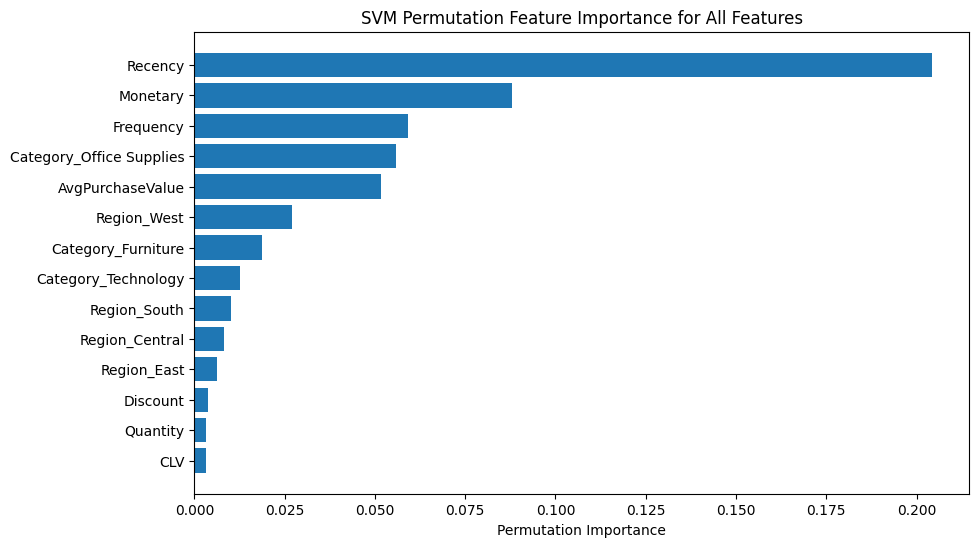

In [36]:
def evaluate_model(descriptive_set_name, X, y, model, ml_alg):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_test_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_classification_rep = classification_report(y_test, y_test_pred)

    print(f"{ml_alg} Test Accuracy with {descriptive_set_name}: {test_accuracy:.4f}")
    print(f"{ml_alg} Test Classification Report with {descriptive_set_name}:")
    print(test_classification_rep)
    print("\n" + "="*60 + "\n")

    perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()

    # Feature names for the current set of features
    feature_names = X.columns

    # Plotting the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title(f"SVM Permutation Feature Importance for {descriptive_set_name}")
    plt.show()


for set_key, X in feature_sets.items():
    descriptive_set_name = descriptive_names[set_key]
    model = loaded_models[descriptive_set_name]
    evaluate_model(descriptive_set_name, X, y, model, 'SVM')

##Logistic Regression


In [88]:
model_path = '/content/drive/MyDrive/dissertation file/Disssertation testing /Logistic_MLset1.pkl'
loaded_model = joblib.load(model_path)
print(loaded_model)


LogisticRegression(C=10, max_iter=5000, multi_class='auto', penalty='l1',
                   random_state=42, solver='saga')
LogisticRegression(C=100, max_iter=5000, multi_class='auto', random_state=42,
                   solver='saga')
LogisticRegression(C=10, max_iter=5000, multi_class='auto', penalty='l1',
                   random_state=42, solver='saga')
LogisticRegression(C=100, max_iter=5000, multi_class='auto', penalty='l1',
                   random_state=42, solver='saga')


In [89]:
# Dictionary for descriptive names
descriptive_names = {
    'set1': 'All Features'
}

loaded_models = {}

for set_key in feature_sets.keys():
    model_path = f'/content/drive/MyDrive/dissertation file/Disssertation testing /Logistic_ML{set_key}.pkl'
    loaded_model = joblib.load(model_path)
    descriptive_name = descriptive_names[set_key]
    loaded_models[descriptive_name] = loaded_model
    print(f"Model '{descriptive_name}' loaded from {model_path}")


Model 'All Features' loaded from /content/drive/MyDrive/dissertation file/Disssertation testing /Logistic_MLset1.pkl


Logistic Regression Test Accuracy with All Features: 0.9245
Logistic Regression Test Classification Report with All Features:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91        41
           1       0.90      0.99      0.94        85
           2       0.95      0.86      0.90        22
           3       1.00      0.73      0.84        11

    accuracy                           0.92       159
   macro avg       0.95      0.86      0.90       159
weighted avg       0.93      0.92      0.92       159





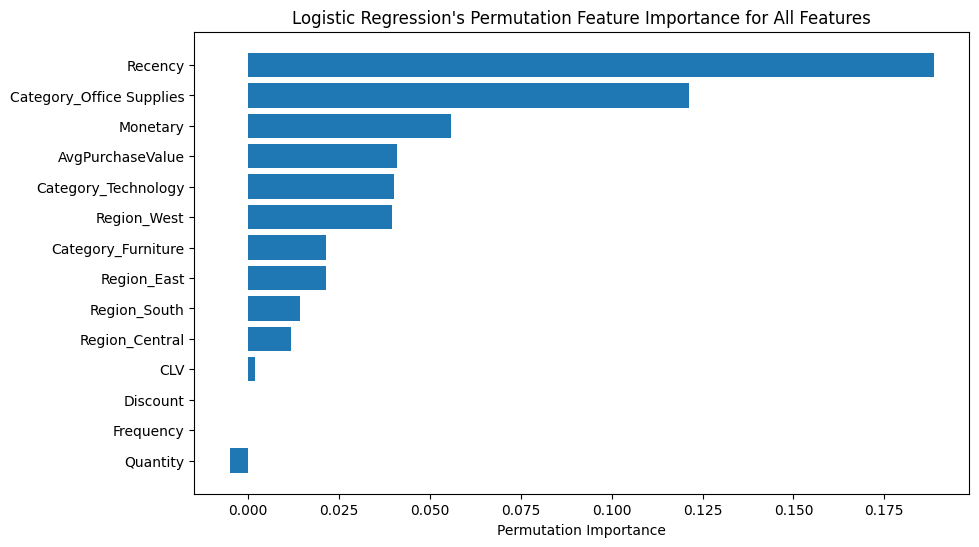

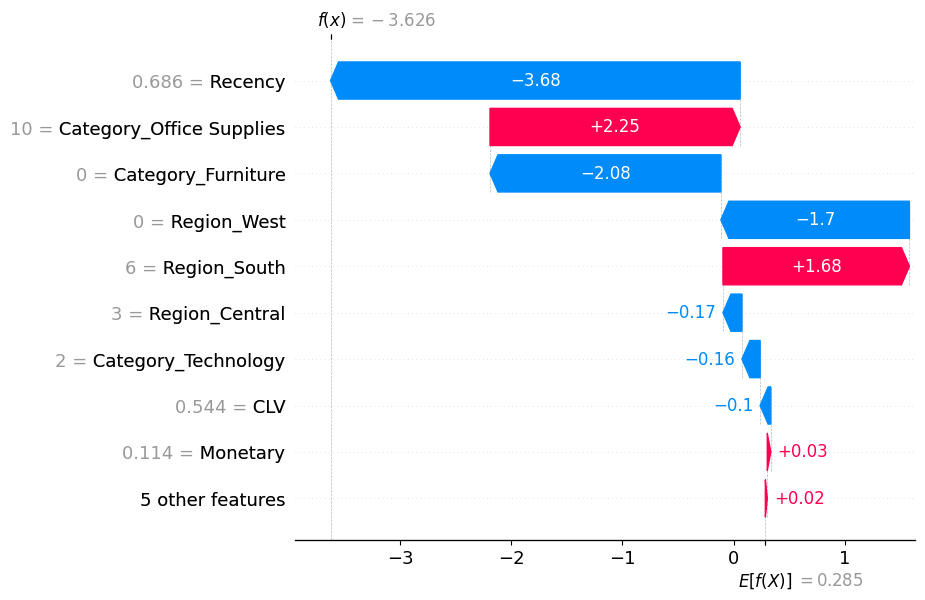

In [90]:
def evaluate_model(descriptive_set_name, X, y, model, ml_alg):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluate the model on the testing data
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_classification_rep = classification_report(y_test, y_test_pred)

    print(f"{ml_alg} Test Accuracy with {descriptive_set_name}: {test_accuracy:.4f}")
    print(f"{ml_alg} Test Classification Report with {descriptive_set_name}:")
    print(test_classification_rep)
    print("\n" + "="*60 + "\n")

    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title(f"{ml_alg}'s Permutation Feature Importance for {descriptive_set_name}")
    plt.show()

    # SHAP Values
    explainer = shap.Explainer(model, X_test)

    # Compute SHAP values
    shap_values = explainer(X_test)

    shap.plots.waterfall(shap_values[0][:, 0])

for set_key, X in feature_sets.items():
    descriptive_set_name = descriptive_names[set_key]
    model = loaded_models[descriptive_set_name]
    evaluate_model(descriptive_set_name, X, y, model, 'Logistic Regression')

## Random Forest


In [27]:
descriptive_names = {
    'set1': 'All Features'
}

loaded_models = {}

for set_key in feature_sets.keys():
    model_path = f'/content/drive/MyDrive/dissertation file/Disssertation testing /RF_ML{set_key}.pkl'
    loaded_model = joblib.load(model_path)
    descriptive_name = descriptive_names[set_key]
    loaded_models[descriptive_name] = loaded_model
    print(f"Model '{descriptive_name}' loaded from {model_path}")


Model 'All Features' loaded from /content/drive/MyDrive/dissertation file/Disssertation testing /RF_MLset1.pkl


Random Forest Test Accuracy with All Features: 0.9560
Random Forest Test Classification Report with All Features:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        41
           1       0.97      1.00      0.98        85
           2       1.00      0.91      0.95        22
           3       1.00      0.82      0.90        11

    accuracy                           0.96       159
   macro avg       0.97      0.91      0.94       159
weighted avg       0.96      0.96      0.96       159





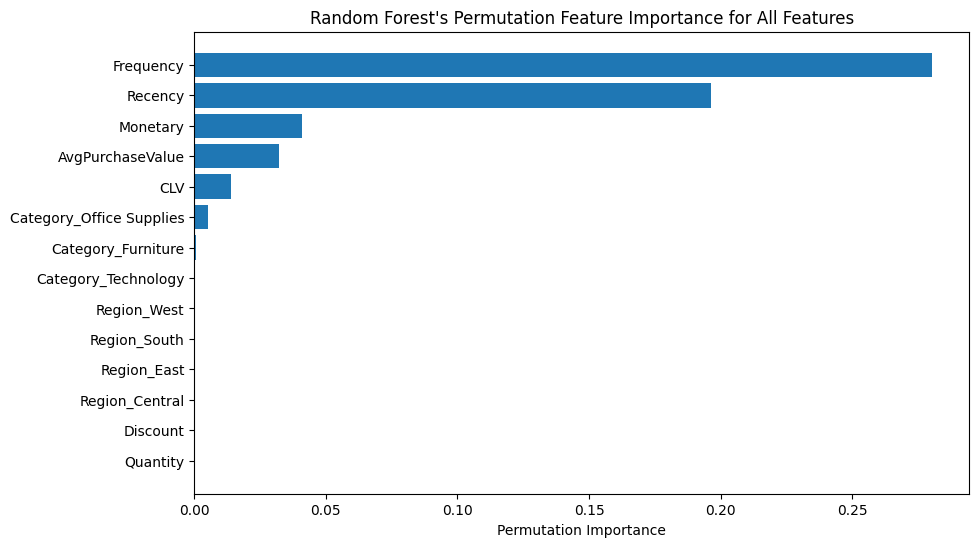

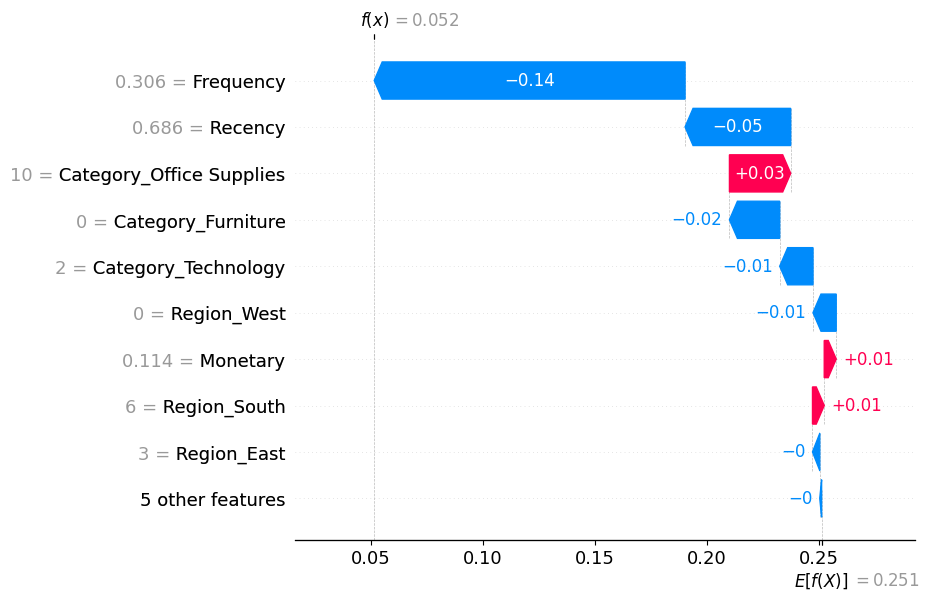

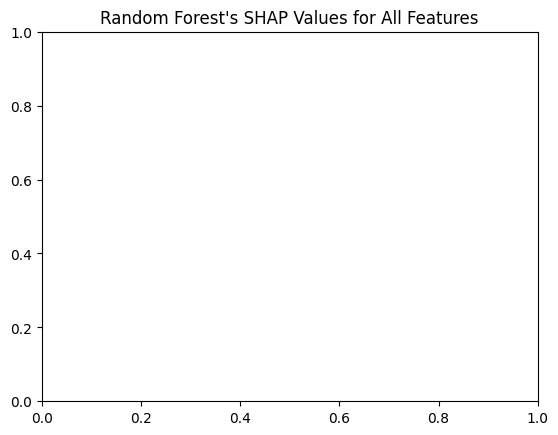

In [28]:
def evaluate_model(descriptive_set_name, X, y, model, ml_alg):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluate the model on the testing data
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_classification_rep = classification_report(y_test, y_test_pred)

    print(f"{ml_alg} Test Accuracy with {descriptive_set_name}: {test_accuracy:.4f}")
    print(f"{ml_alg} Test Classification Report with {descriptive_set_name}:")
    print(test_classification_rep)
    print("\n" + "="*60 + "\n")

    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title(f"{ml_alg}'s Permutation Feature Importance for {descriptive_set_name}")
    plt.show()

    # SHAP Values
    explainer = shap.Explainer(model, X_test)

    # Compute SHAP values
    shap_values = explainer(X_test, check_additivity=False)

    shap.plots.waterfall(shap_values[0][:, 0])
    plt.title(f"{ml_alg}'s SHAP Values for {descriptive_set_name}")
    plt.show()

for set_key, X in feature_sets.items():
    descriptive_set_name = descriptive_names[set_key]
    model = loaded_models[descriptive_set_name]
    evaluate_model(descriptive_set_name, X, y, model, 'Random Forest')




## XGBoost

In [ ]:
model_path = '/content/drive/MyDrive/dissertation file/Disssertation testing /XG_MLset1.pkl'
loaded_model = joblib.load(model_path)
print(loaded_model)

In [29]:
descriptive_names = {
    'set1': 'All Features'
}
loaded_models = {}

for set_key in feature_sets.keys():
    model_path = f'/content/drive/MyDrive/dissertation file/Disssertation testing /XG_ML{set_key}.pkl'
    loaded_model = joblib.load(model_path)
    descriptive_name = descriptive_names[set_key]
    loaded_models[descriptive_name] = loaded_model
    print(f"Model '{descriptive_name}' loaded from {model_path}")

Model 'All Features' loaded from /content/drive/MyDrive/dissertation file/Disssertation testing /XG_MLset1.pkl


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:37:11] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


XGBoost Test Accuracy with All Features: 0.9560
XGBoost Test Classification Report with All Features:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        41
           1       0.97      0.99      0.98        85
           2       1.00      0.95      0.98        22
           3       0.90      0.82      0.86        11

    accuracy                           0.96       159
   macro avg       0.95      0.92      0.93       159
weighted avg       0.96      0.96      0.96       159





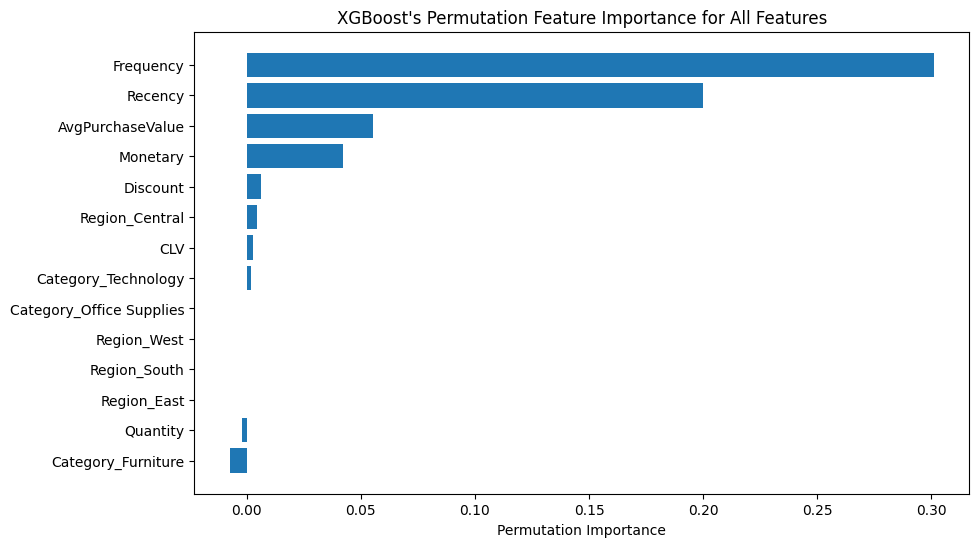

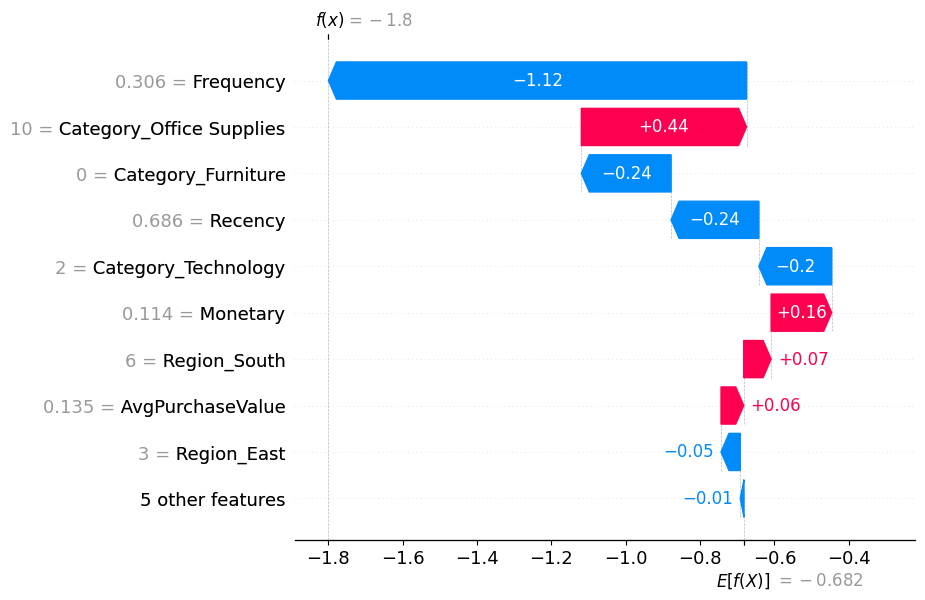

In [30]:
def evaluate_model(descriptive_set_name, X, y, model, ml_alg):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluate the model on the testing data
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_classification_rep = classification_report(y_test, y_test_pred)

    print(f"{ml_alg} Test Accuracy with {descriptive_set_name}: {test_accuracy:.4f}")
    print(f"{ml_alg} Test Classification Report with {descriptive_set_name}:")
    print(test_classification_rep)
    print("\n" + "="*60 + "\n")

    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title(f"{ml_alg}'s Permutation Feature Importance for {descriptive_set_name}")
    plt.show()

    # SHAP Values
    explainer = shap.Explainer(model, X_test)

    # Compute SHAP values
    shap_values = explainer(X_test, check_additivity=False)

    shap.plots.waterfall(shap_values[0][:, 0])

for set_key, X in feature_sets.items():
    descriptive_set_name = descriptive_names[set_key]
    model = loaded_models[descriptive_set_name]
    evaluate_model(descriptive_set_name, X, y, model, 'XGBoost')

## LightGBM

In [31]:
model_path = '/content/drive/MyDrive/dissertation file/Disssertation testing /LightGBM_MLset1.pkl'
loaded_model = joblib.load(model_path)
print(loaded_model)


LGBMClassifier(colsample_bytree=0.874789149988036,
               learning_rate=0.029649472448942955, max_depth=4,
               min_child_weight=10, n_estimators=62, num_leaves=10,
               reg_alpha=0.5686931597949703, reg_lambda=0.5148195023376652,
               subsample=0.6367035359653531)


In [33]:
loaded_models = {}
for set_key in feature_sets.keys():
    model_path = f'/content/drive/MyDrive/dissertation file/Disssertation testing /LightGBM_ML{set_key}.pkl'
    loaded_model = joblib.load(model_path)
    descriptive_name = descriptive_names[set_key]
    loaded_models[descriptive_name] = loaded_model
    print(f"Model '{descriptive_name}' loaded from {model_path}")

Model 'All Features' loaded from /content/drive/MyDrive/dissertation file/Disssertation testing /LightGBM_MLset1.pkl


LightGBM Test Accuracy with All Features: 0.9371
LightGBM Test Classification Report with All Features:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        41
           1       0.97      0.98      0.97        85
           2       0.95      0.95      0.95        22
           3       0.80      0.73      0.76        11

    accuracy                           0.94       159
   macro avg       0.91      0.89      0.90       159
weighted avg       0.94      0.94      0.94       159





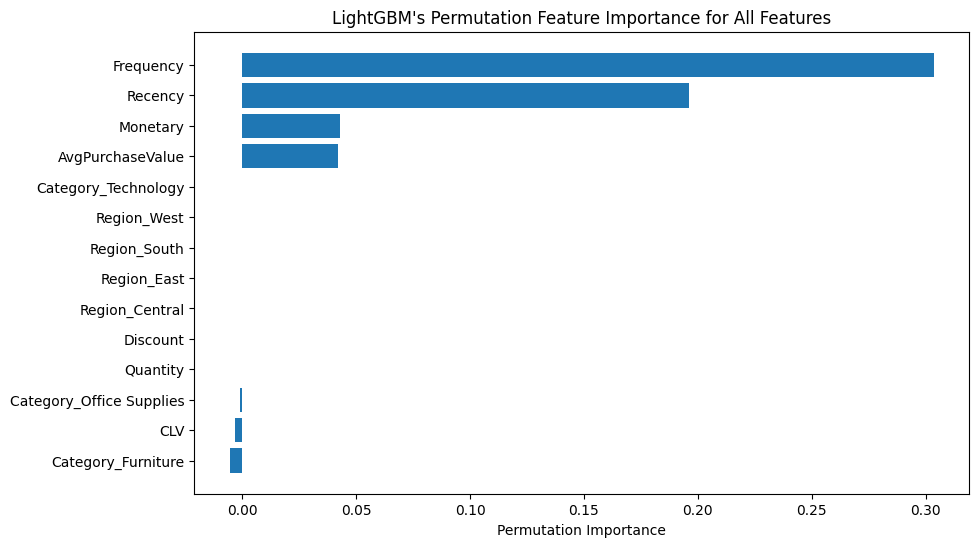

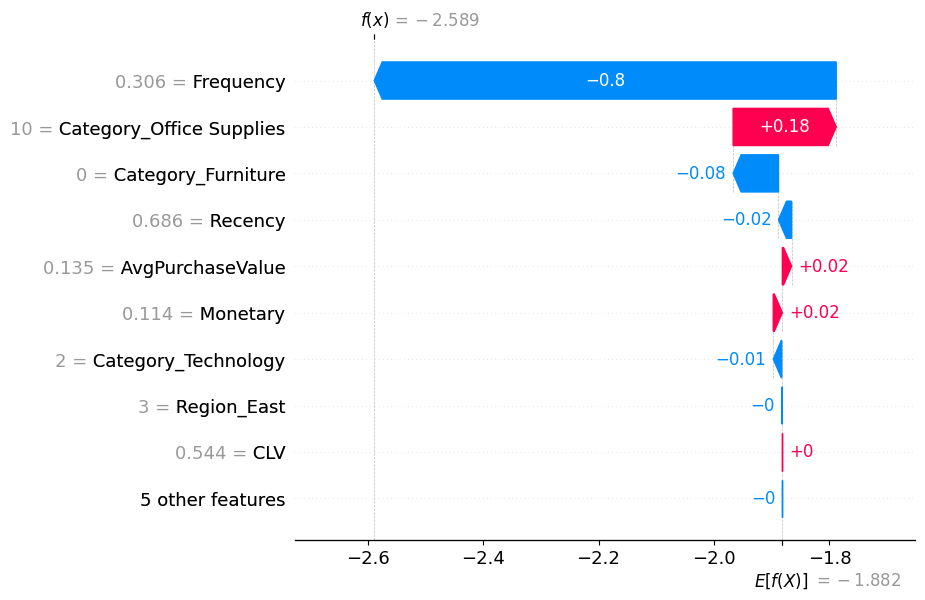

In [34]:
def evaluate_model(descriptive_set_name, X, y, model, ml_alg):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluate the model on the testing data
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_classification_rep = classification_report(y_test, y_test_pred)

    print(f"{ml_alg} Test Accuracy with {descriptive_set_name}: {test_accuracy:.4f}")
    print(f"{ml_alg} Test Classification Report with {descriptive_set_name}:")
    print(test_classification_rep)
    print("\n" + "="*60 + "\n")

    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title(f"{ml_alg}'s Permutation Feature Importance for {descriptive_set_name}")
    plt.show()

    # SHAP Values
    explainer = shap.Explainer(model, X_test)

    # Compute SHAP values
    shap_values = explainer(X_test, check_additivity=False)

    shap.plots.waterfall(shap_values[0][:, 0])

for set_key, X in feature_sets.items():
    descriptive_set_name = descriptive_names[set_key]
    model = loaded_models[descriptive_set_name]
    evaluate_model(descriptive_set_name, X, y, model, 'LightGBM')